# Домашняя работа по машинному обучению в бизнесе №5

##### Задание1 
Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)

In [19]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [20]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [ ]:
Есть как категориальные, так и вещественные признаки. Поле CustomerId нужно будет удалить.

Посмотрим на распределение классов:

In [21]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [ ]:
Распределение 1:3.Не очень здорово,но и не очень плохо.Средне

In [ ]:
 Построим модель. Сразу же будем работать с использованием sklearn pipeline

In [22]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [ ]:
Категориальные признаки закодируем с помощью OneHotEncoding
Вещественные оставим пока как есть

In [23]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [24]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [25]:
df['Geography'].value_counts()


France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [ ]:
Зададим списки признаков

In [26]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

gender = Pipeline([
                ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
9394,1,0
898,1,0
2398,1,0


In [ ]:
Теперь нам нужно под каждый признак создать трансформер и объединить их в список (сделаем это в цикле, чтобы не мучиться)

In [28]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

In [ ]:
Объединим все это в единый пайплайн

In [29]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [ ]:
Теперь у нас есть пайплайн, который готовит признаки для моделирования.

Добавим модель

In [12]:
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

In [ ]:
Обучим модель

In [13]:
#обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [14]:
#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.37, 0.26, 0.16, 0.02, 0.02, 0.67, 0.04, 0.12, 0.15, 0.75])

In [24]:
Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем,
что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

SyntaxError: invalid syntax (<ipython-input-24-c04cda3938c0>, line 1)

In [15]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [16]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.380000, F-Score=0.641, Precision=0.653, Recall=0.629


In [ ]:
Отрисуем матрицу ошибок

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1832  159]
 [ 195  314]]


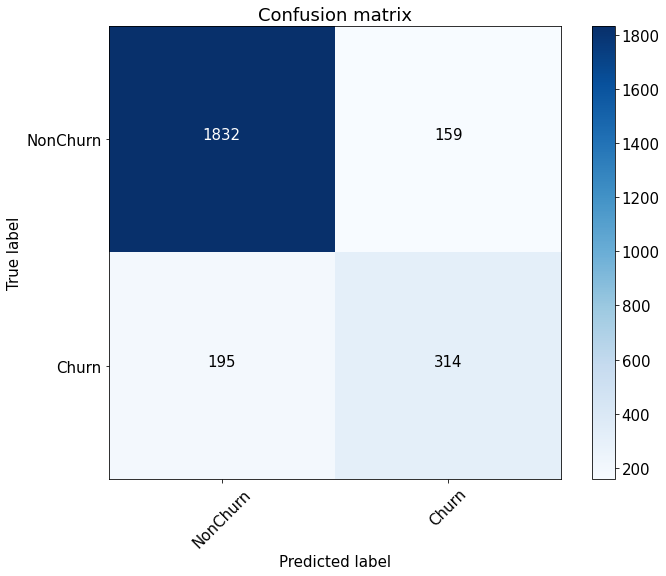

In [28]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [ ]:
Можно заметить, что мы очень сильно ошибаемся в сторону False Negatives, т.е у нас много тех, 
кто ушел в отток на самом деле, но при выбранном нами пороге в 0.38 мы не считаем их таковыми.

In [18]:
from catboost import CatBoostClassifier

In [32]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', CatBoostClassifier(random_state = 42)),
])

In [ ]:
Обучим модель

In [33]:
#обучим наш пайплайн
pipeline.fit(X_train, y_train)

Learning rate set to 0.024355
0:	learn: 0.6726374	total: 175ms	remaining: 2m 55s
1:	learn: 0.6548174	total: 185ms	remaining: 1m 32s
2:	learn: 0.6405685	total: 192ms	remaining: 1m 3s
3:	learn: 0.6237743	total: 203ms	remaining: 50.6s
4:	learn: 0.6080844	total: 212ms	remaining: 42.1s
5:	learn: 0.5929243	total: 219ms	remaining: 36.3s
6:	learn: 0.5787577	total: 226ms	remaining: 32s
7:	learn: 0.5659958	total: 233ms	remaining: 28.8s
8:	learn: 0.5556154	total: 238ms	remaining: 26.2s
9:	learn: 0.5441443	total: 243ms	remaining: 24.1s
10:	learn: 0.5348181	total: 249ms	remaining: 22.4s
11:	learn: 0.5257042	total: 253ms	remaining: 20.8s
12:	learn: 0.5169250	total: 258ms	remaining: 19.6s
13:	learn: 0.5074365	total: 264ms	remaining: 18.6s
14:	learn: 0.4985522	total: 269ms	remaining: 17.7s
15:	learn: 0.4914367	total: 275ms	remaining: 16.9s
16:	learn: 0.4826085	total: 281ms	remaining: 16.2s
17:	learn: 0.4757232	total: 286ms	remaining: 15.6s
18:	learn: 0.4680217	total: 291ms	remaining: 15s
19:	learn: 0.

193:	learn: 0.3144286	total: 1.31s	remaining: 5.45s
194:	learn: 0.3142515	total: 1.32s	remaining: 5.44s
195:	learn: 0.3141753	total: 1.32s	remaining: 5.43s
196:	learn: 0.3139748	total: 1.33s	remaining: 5.43s
197:	learn: 0.3138253	total: 1.34s	remaining: 5.42s
198:	learn: 0.3136712	total: 1.34s	remaining: 5.41s
199:	learn: 0.3135645	total: 1.35s	remaining: 5.39s
200:	learn: 0.3134119	total: 1.35s	remaining: 5.38s
201:	learn: 0.3133071	total: 1.36s	remaining: 5.37s
202:	learn: 0.3130777	total: 1.36s	remaining: 5.36s
203:	learn: 0.3129645	total: 1.37s	remaining: 5.35s
204:	learn: 0.3127758	total: 1.38s	remaining: 5.33s
205:	learn: 0.3124967	total: 1.38s	remaining: 5.32s
206:	learn: 0.3123548	total: 1.39s	remaining: 5.31s
207:	learn: 0.3122660	total: 1.39s	remaining: 5.3s
208:	learn: 0.3120087	total: 1.4s	remaining: 5.29s
209:	learn: 0.3119176	total: 1.4s	remaining: 5.28s
210:	learn: 0.3118129	total: 1.41s	remaining: 5.27s
211:	learn: 0.3117460	total: 1.41s	remaining: 5.26s
212:	learn: 0.3

374:	learn: 0.2912251	total: 2.42s	remaining: 4.03s
375:	learn: 0.2910964	total: 2.42s	remaining: 4.03s
376:	learn: 0.2910322	total: 2.43s	remaining: 4.02s
377:	learn: 0.2909866	total: 2.44s	remaining: 4.01s
378:	learn: 0.2908745	total: 2.44s	remaining: 4s
379:	learn: 0.2907327	total: 2.45s	remaining: 4s
380:	learn: 0.2906548	total: 2.46s	remaining: 3.99s
381:	learn: 0.2905668	total: 2.46s	remaining: 3.98s
382:	learn: 0.2903557	total: 2.47s	remaining: 3.97s
383:	learn: 0.2902225	total: 2.47s	remaining: 3.96s
384:	learn: 0.2900906	total: 2.48s	remaining: 3.96s
385:	learn: 0.2900180	total: 2.48s	remaining: 3.95s
386:	learn: 0.2899061	total: 2.49s	remaining: 3.94s
387:	learn: 0.2897499	total: 2.49s	remaining: 3.93s
388:	learn: 0.2896423	total: 2.5s	remaining: 3.92s
389:	learn: 0.2895613	total: 2.5s	remaining: 3.92s
390:	learn: 0.2894453	total: 2.51s	remaining: 3.91s
391:	learn: 0.2893301	total: 2.52s	remaining: 3.9s
392:	learn: 0.2892394	total: 2.52s	remaining: 3.89s
393:	learn: 0.2891020

546:	learn: 0.2712227	total: 3.38s	remaining: 2.8s
547:	learn: 0.2711231	total: 3.39s	remaining: 2.8s
548:	learn: 0.2710301	total: 3.4s	remaining: 2.79s
549:	learn: 0.2709393	total: 3.41s	remaining: 2.79s
550:	learn: 0.2708655	total: 3.41s	remaining: 2.78s
551:	learn: 0.2707747	total: 3.42s	remaining: 2.77s
552:	learn: 0.2706704	total: 3.42s	remaining: 2.77s
553:	learn: 0.2705577	total: 3.43s	remaining: 2.76s
554:	learn: 0.2704050	total: 3.43s	remaining: 2.75s
555:	learn: 0.2702776	total: 3.44s	remaining: 2.75s
556:	learn: 0.2701332	total: 3.44s	remaining: 2.74s
557:	learn: 0.2700162	total: 3.45s	remaining: 2.73s
558:	learn: 0.2698756	total: 3.46s	remaining: 2.73s
559:	learn: 0.2697172	total: 3.46s	remaining: 2.72s
560:	learn: 0.2696594	total: 3.47s	remaining: 2.71s
561:	learn: 0.2695824	total: 3.47s	remaining: 2.71s
562:	learn: 0.2694121	total: 3.48s	remaining: 2.7s
563:	learn: 0.2693203	total: 3.48s	remaining: 2.69s
564:	learn: 0.2692196	total: 3.49s	remaining: 2.69s
565:	learn: 0.26

715:	learn: 0.2545285	total: 4.36s	remaining: 1.73s
716:	learn: 0.2544285	total: 4.36s	remaining: 1.72s
717:	learn: 0.2543627	total: 4.37s	remaining: 1.72s
718:	learn: 0.2542631	total: 4.38s	remaining: 1.71s
719:	learn: 0.2541166	total: 4.38s	remaining: 1.7s
720:	learn: 0.2540050	total: 4.39s	remaining: 1.7s
721:	learn: 0.2538459	total: 4.39s	remaining: 1.69s
722:	learn: 0.2537905	total: 4.4s	remaining: 1.69s
723:	learn: 0.2537382	total: 4.4s	remaining: 1.68s
724:	learn: 0.2537076	total: 4.41s	remaining: 1.67s
725:	learn: 0.2536236	total: 4.41s	remaining: 1.67s
726:	learn: 0.2535437	total: 4.42s	remaining: 1.66s
727:	learn: 0.2534612	total: 4.43s	remaining: 1.65s
728:	learn: 0.2533808	total: 4.43s	remaining: 1.65s
729:	learn: 0.2532684	total: 4.44s	remaining: 1.64s
730:	learn: 0.2531838	total: 4.44s	remaining: 1.63s
731:	learn: 0.2530769	total: 4.45s	remaining: 1.63s
732:	learn: 0.2529907	total: 4.45s	remaining: 1.62s
733:	learn: 0.2528853	total: 4.46s	remaining: 1.62s
734:	learn: 0.25

889:	learn: 0.2398060	total: 5.33s	remaining: 658ms
890:	learn: 0.2397371	total: 5.33s	remaining: 653ms
891:	learn: 0.2396670	total: 5.34s	remaining: 647ms
892:	learn: 0.2396118	total: 5.35s	remaining: 641ms
893:	learn: 0.2395218	total: 5.35s	remaining: 635ms
894:	learn: 0.2394330	total: 5.36s	remaining: 629ms
895:	learn: 0.2393283	total: 5.36s	remaining: 623ms
896:	learn: 0.2392039	total: 5.37s	remaining: 617ms
897:	learn: 0.2391078	total: 5.38s	remaining: 611ms
898:	learn: 0.2389811	total: 5.38s	remaining: 605ms
899:	learn: 0.2388662	total: 5.39s	remaining: 599ms
900:	learn: 0.2388047	total: 5.39s	remaining: 593ms
901:	learn: 0.2387421	total: 5.4s	remaining: 586ms
902:	learn: 0.2386572	total: 5.4s	remaining: 580ms
903:	learn: 0.2385840	total: 5.41s	remaining: 574ms
904:	learn: 0.2385132	total: 5.41s	remaining: 568ms
905:	learn: 0.2384326	total: 5.42s	remaining: 562ms
906:	learn: 0.2383329	total: 5.42s	remaining: 556ms
907:	learn: 0.2382519	total: 5.43s	remaining: 550ms
908:	learn: 0.

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [34]:
#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.46917705, 0.24499582, 0.11518556, 0.04942908, 0.02369729,
       0.87775373, 0.02032456, 0.13019025, 0.16192791, 0.91391094])

In [ ]:
Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем,
что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [35]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [36]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.384476, F-Score=0.645, Precision=0.661, Recall=0.629


In [ ]:
Отсечка стала ненамного выше,метрика F-Score чуть улучшилась,но в целом картину не меняет.Полнота вообще осталаст неизменной

##### Вывод: обе из предложенных моделей справились с задачей одинаково.Выбираю модель catboost

In [37]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1827  164]
 [ 190  319]]


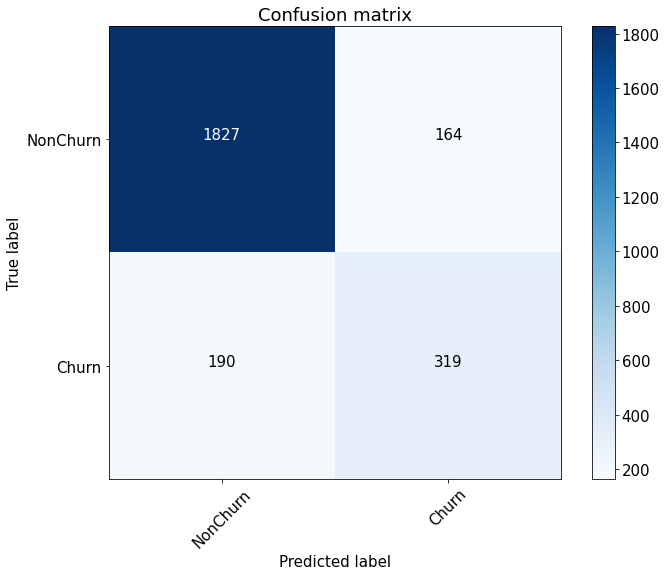

In [38]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

##### Задание 3
Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2:
1 доллар на удержание
2 доллара - с каждого правильно классифицированного (True Positive)

In [39]:
TN = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]


retain_sum = (FP + TP) * 1
income = TP * 2

income - retain_sum

155

In [ ]:
Вывод: с экономической точки зрения модели ничем не отличаются.Результат обоих моделей одинаковый :155